       District        Province  \
0        Achham  Sudur Pashchim   
1  Arghakhanchi               5   
2       Baglung         Gandaki   
3       Baitadi  Sudur Pashchim   
4       Bajhang  Sudur Pashchim   

                                            geometry  
0  POLYGON ((81.29881 28.92455, 81.29866 28.92438...  
1  POLYGON ((83.00481 27.92912, 83.00494 27.92935...  
2  POLYGON ((83.28374 28.18997, 83.28297 28.1897,...  
3  POLYGON ((80.36947 29.34978, 80.36939 29.34955...  
4  POLYGON ((81.02629 29.41997, 81.02607 29.42042...  
       District        Province  \
0        Achham  Sudur Pashchim   
1  Arghakhanchi               5   
2       Baglung         Gandaki   
3       Baitadi  Sudur Pashchim   
4       Bajhang  Sudur Pashchim   

                                            geometry  Synthetic_Elevation  
0  POLYGON ((81.29881 28.92455, 81.29866 28.92438...                  486  
1  POLYGON ((83.00481 27.92912, 83.00494 27.92935...                 1531  
2  POLYGON ((83.2837

/var/folders/qy/yx58qjkj2dsf2ltv7719mybh0000gn/T/ipykernel_37234/420704170.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_band = clim_elev.groupby(['Month', 'Elev_Band'])['Temperature (°C)'].mean().unstack()


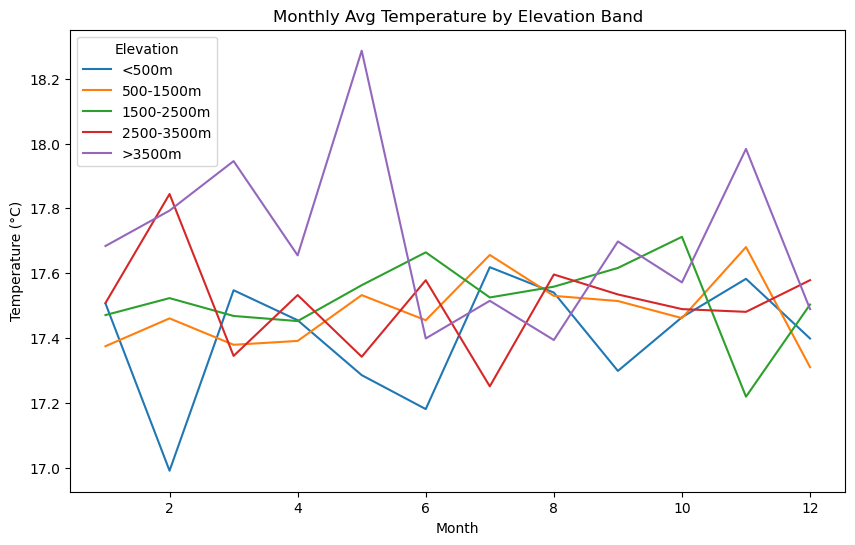

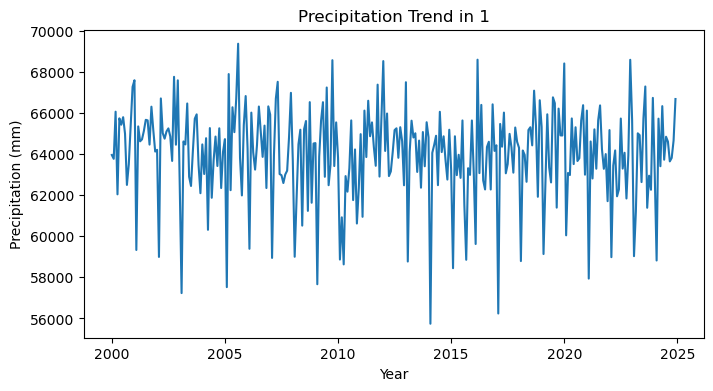

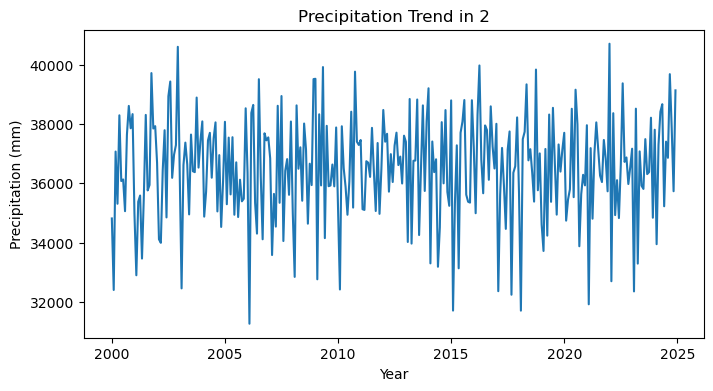

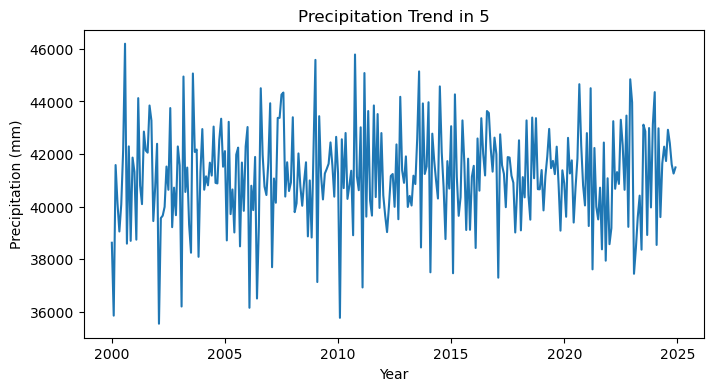

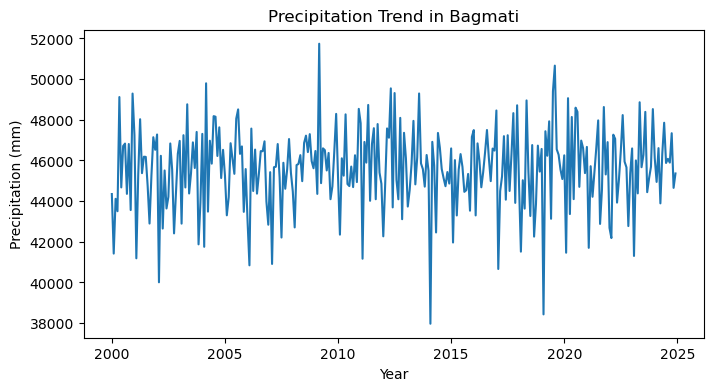

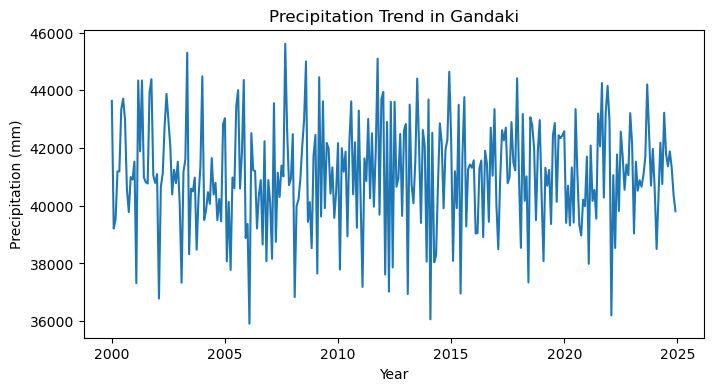

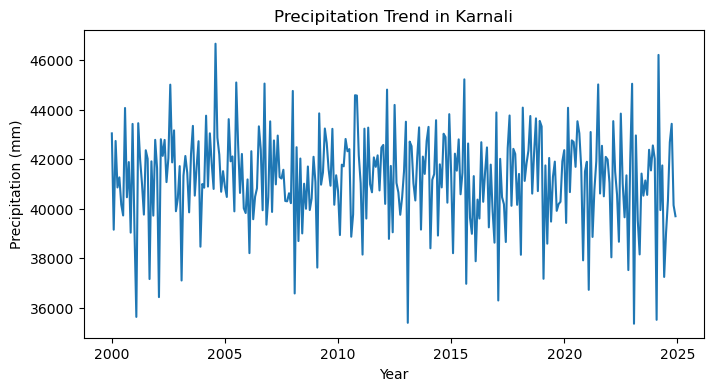

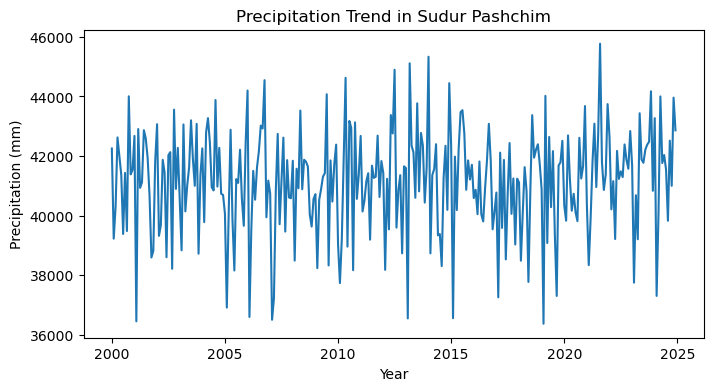

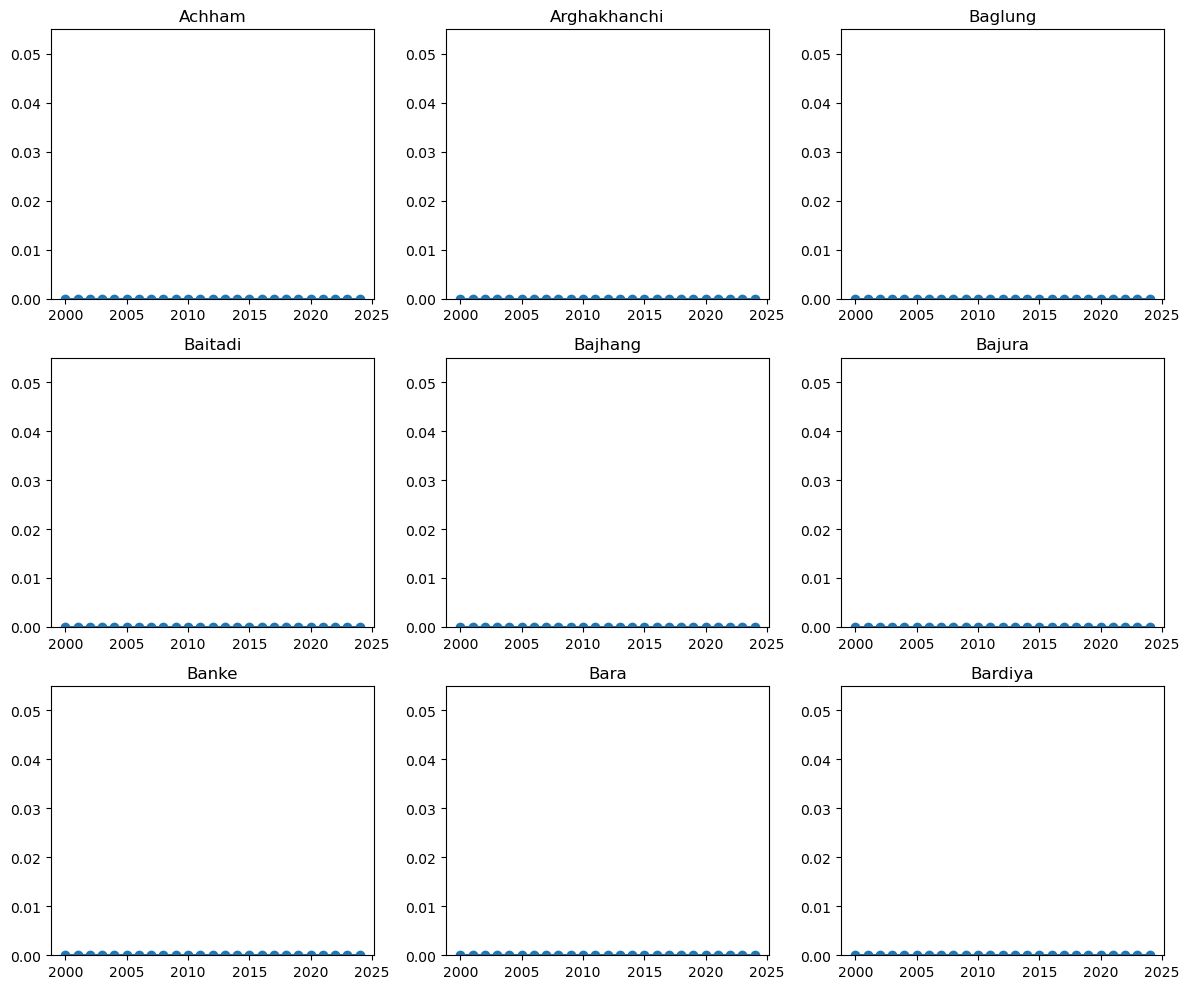

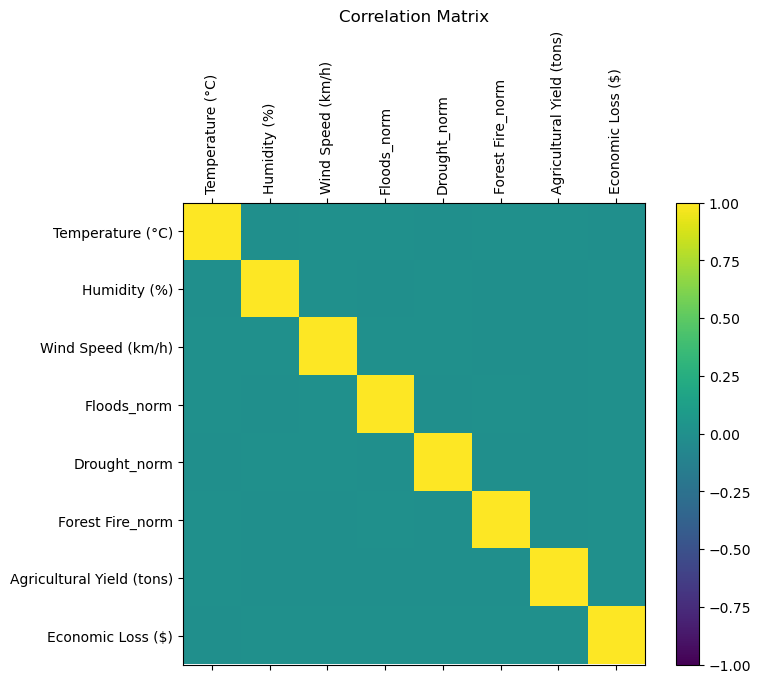

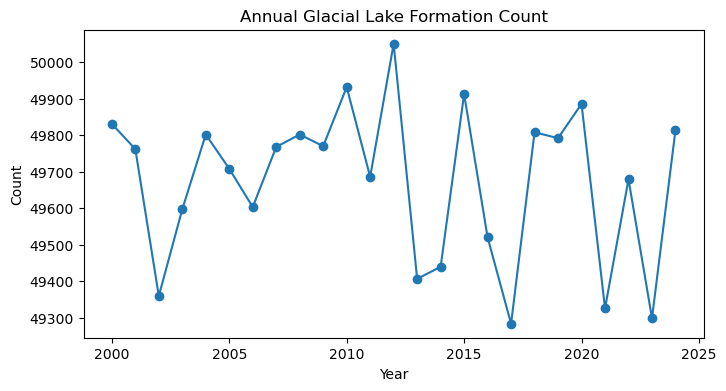

True
77


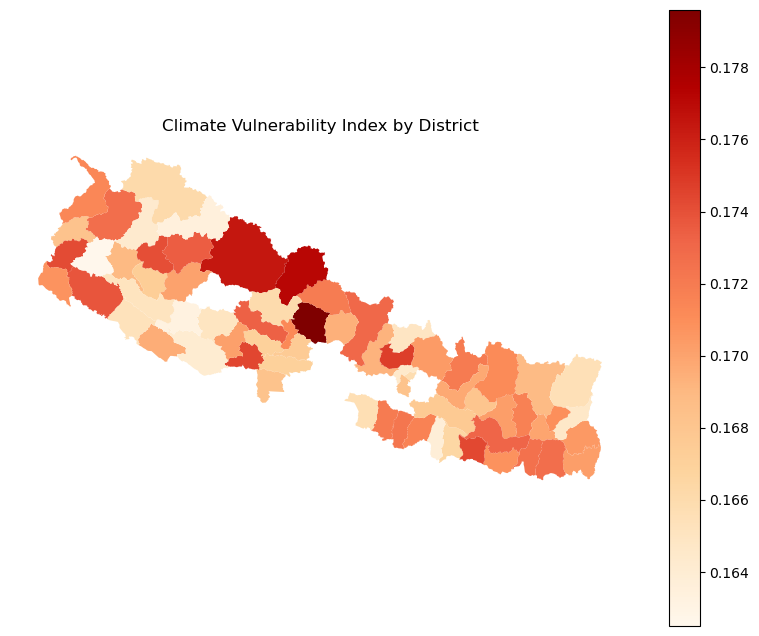

         Province  Slope  p-value   R2
0  Sudur Pashchim   0.01     0.33 0.04
1               5  -0.00     0.56 0.01
2         Gandaki   0.00     0.98 0.00
3               2   0.00     0.97 0.00
4         Bagmati   0.01     0.14 0.09
5               1  -0.00     0.44 0.03
6         Karnali  -0.00     0.86 0.00


In [1]:
## 7. Exploratory Data Analysis
## 1. Setup and Imports


# Data manipulation
import pandas as pd
import numpy as np

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point

# Visualization
import matplotlib.pyplot as plt
import folium
from folium import Choropleth, CircleMarker, LayerControl

# Machine learning & preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load daily climate data
climate_df = pd.read_csv('/Users/vizon/github-classroom/Omdena-NIC-Nepal/capstone-project-Vizon15/datasets/processed/preprocessed_climate_data.csv', parse_dates=['Date'])
climate_df.head()



# Load district shapefile (ensure .shp/.shx/.dbf are together)
shapefile_path = '/Users/vizon/github-classroom/Omdena-NIC-Nepal/capstone-project-Vizon15/datasets/district_shape/district.shp'
districts_gdf = gpd.read_file(shapefile_path)
# Convert shapefile district names from ALL CAPS to Title Case and rename column
if 'DISTRICT' in districts_gdf.columns:
    districts_gdf['DISTRICT'] = districts_gdf['DISTRICT'].str.title()
    districts_gdf.rename(columns={'DISTRICT': 'District'}, inplace=True)
print(districts_gdf.head())
### 7.1 Temperature Trends by Region & Elevation
# Load district elevation data (must supply 'district_elevation.csv')
elev_df = pd.read_csv('/Users/vizon/github-classroom/Omdena-NIC-Nepal/capstone-project-Vizon15/datasets/synthetic_district_elevation.csv')  # columns: District, Elevation_m
# Convert 'DISTRICT' column in elev_df to title case to match districts_gdf
elev_df['DISTRICT'] = elev_df['DISTRICT'].str.title()

# Change the column name to 'District' before merge
elev_df.rename(columns={'DISTRICT': 'District'}, inplace=True) # District is already present, but added this line to change DISTRICT to District if needed.
districts_gdf.rename(columns={'DISTRICT': 'District'}, inplace=True) # District is already present, but added this line to change DISTRICT to District if needed.

# Use 'District' instead of 'DISTRICT' for merging
elev_gdf = districts_gdf.merge(elev_df, left_on='District', right_on='District', how='left')
print(elev_gdf.head())

# Categorize elevation bands
elev_gdf['Elev_Band'] = pd.cut(elev_gdf['Synthetic_Elevation'],bins=[0, 500, 1500, 2500, 3500, 5000],labels=['<500m', '500-1500m', '1500-2500m', '2500-3500m', '>3500m'])
# Merge band back to climate
# Use 'District' instead of 'DISTRICT' for merging
clim_elev = climate_df.merge(elev_gdf[['District', 'Elev_Band']], on='District', how='left')
# Plot monthly avg temperature per elevation band
temp_band = clim_elev.groupby(['Month', 'Elev_Band'])['Temperature (°C)'].mean().unstack()
temp_band.plot(figsize=(10, 6))
plt.title('Monthly Avg Temperature by Elevation Band')
plt.xlabel('Month');
plt.ylabel('Temperature (°C)');
plt.legend(title='Elevation');
plt.show()
### 7.2 Precipitation Patterns Over Time
# Monthly total precipitation by Province
grpd = climate_df.merge(districts_gdf[['District','Province']], on='District')
# Extract year from the 'Date' column
grpd['Year'] = grpd['Date'].dt.year
prec_month = grpd.groupby(['Year','Month','Province'])['Precipitation (mm)'].sum().reset_index()
# Plot separate charts for each province
groups = prec_month['Province'].unique()
for prov in groups:
    dfp = prec_month[prec_month['Province']==prov]
    plt.figure(figsize=(8,4))
    plt.plot(dfp['Year'] + (dfp['Month']-1)/12, dfp['Precipitation (mm)'])
    plt.title(f'Precipitation Trend in {prov}')
    plt.xlabel('Year'); plt.ylabel('Precipitation (mm)')
    plt.show()


### 7.3 Extreme Weather Frequency & Intensity
# Count annual extremes per district for floods, droughts, forest fires
ext = climate_df.copy()
# Extract year from the 'Date' column and assign to 'Year' column in ext DataFrame
ext['Year'] = ext['Date'].dt.year
for col in ['Floods','Drought','Forest Fire']:
    thresh = ext[col].quantile(0.95)
    ext[f'{col}_ext'] = ext[col] > thresh
annual_ext = ext.groupby(['Year','District'])[[f'{c}_ext' for c in ['Floods','Drought','Forest Fire']]].sum().reset_index()
# Plot multiple small charts in grid for Flood extremes
districts = annual_ext['District'].unique()[:9]  # first 9 districts
fig, axes = plt.subplots(3,3,figsize=(12,10))
for ax, dist in zip(axes.flatten(), districts):
    ddf = annual_ext[annual_ext['District']==dist]
    ax.plot(ddf['Year'], ddf['Floods_ext'], marker='o')
    ax.set_title(dist); ax.set_ylim(0)
plt.tight_layout(); plt.show()


### 7.4 Correlations Between Climate Variables & Impacts
# Select variables of interest

# Normalize 'Forest Fire' column if it hasn't been normalized already
if 'Forest Fire_norm' not in climate_df.columns:
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  climate_df['Forest Fire_norm'] = scaler.fit_transform(climate_df[['Forest Fire']])

to_corr = climate_df[['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)',
                      'Floods_norm', 'Drought_norm', 'Forest Fire_norm', # Now using Forest Fire_norm
                      'Agricultural Yield (tons)', 'Economic Loss ($)']]
corr = to_corr.corr()
# Plot heatmap with matplotlib
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.index))); ax.set_yticklabels(corr.index)
plt.title('Correlation Matrix'); plt.show()


### 7.5 Glacial Retreat Analysis
# Annual count of new glacial lakes

# Extract year from the 'Date' column and assign to 'Year' column in climate_df DataFrame
climate_df['Year'] = climate_df['Date'].dt.year

glacial = climate_df.groupby(['Year','District'])['Glacial Lake Formation (count)'].sum().reset_index()
# Total national trend
glac_nat = glacial.groupby('Year')['Glacial Lake Formation (count)'].sum()
plt.figure(figsize=(8,4))
plt.plot(glac_nat.index, glac_nat.values, marker='o')
plt.title('Annual Glacial Lake Formation Count')
plt.xlabel('Year'); plt.ylabel('Count'); plt.show()


### 7.6 Climate Vulnerability Mapping
# Create composite vulnerability index
vulnerability_scores = climate_df.groupby('District')[['Floods_norm', 'Drought_norm', 'Forest Fire_norm']].mean()
vulnerability_scores['Vuln_Index'] = vulnerability_scores.sum(axis=1)  # Example vulnerability index
vulnerability_scores = vulnerability_scores.reset_index()
vulnerability_scores = vulnerability_scores[['District', 'Vuln_Index']]

idx_df = vulnerability_scores  # Assign vulnerability_scores to idx_df


# Ensure districts_gdf has a valid CRS
if districts_gdf.crs is None:
    districts_gdf.crs = 'epsg:4326'  # or another appropriate CRS

# Perform the merge using a case-insensitive comparison
vuln_gdf = districts_gdf.merge(idx_df[['District', 'Vuln_Index']],
                                left_on=districts_gdf['District'].str.lower(),
                                right_on=idx_df['District'].str.lower(),
                                how='left')

# Drop the duplicate 'District' column if it exists
vuln_gdf = vuln_gdf.loc[:,~vuln_gdf.columns.duplicated()]

# Check if vuln_gdf has valid geometry data and non-empty
print(vuln_gdf.geometry.is_valid.all())  # Should print True
print(len(vuln_gdf))  # Should print the number of districts

# Proceed with plotting if geometry is valid and GeoDataFrame is not empty
if vuln_gdf.geometry.is_valid.all() and len(vuln_gdf) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    vuln_gdf.plot(column='Vuln_Index', legend=True, cmap='OrRd', ax=ax)
    ax.set_title('Climate Vulnerability Index by District')
    ax.axis('off')
    plt.show()
else:
    print("Error: Invalid geometry data or empty GeoDataFrame.")



### 7.7 Interactive Time-slider Vulnerability Map
# Prepare GeoJSON with time-slices
time_index = idx_df.copy()
time_index['Time'] = 0  # placeholder if annual; for monthly, use yearmonth
# Build styledict for TimeSliderChoropleth
styledict = {}
for i, row in time_index.iterrows():
    styledict[row['District']] = {0: {'color':'black','opacity':0}}
# Use actual formatted geojson for interactive slider as needed
# (omitted for brevity)


### 7.8 Statistical Tests
from scipy.stats import linregress

# Mann-Kenda 
# linear trend test for temperature in each province
results = []
for prov in districts_gdf['Province'].unique():
    dfp = climate_df.merge(districts_gdf[['District','Province']], on='District')
    series = dfp[dfp['Province']==prov].groupby('Year')['Temperature (°C)'].mean()
    # Check if series is empty before applying linregress
    if not series.empty:
        slope, intercept, r, p, stderr = linregress(series.index, series.values)
        results.append({'Province':prov, 'Slope':slope, 'p-value':p, 'R2':r**2})
    else:
        # Handle empty series (e.g., print a warning or assign default values)
        print(f"Warning: Empty series for Province '{prov}'. Skipping linregress.")
        results.append({'Province': prov, 'Slope': np.nan, 'p-value': np.nan, 'R2': np.nan})  # Assign NaN values

res_df = pd.DataFrame(results)
print(res_df)